In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
# System and OS utilities
import os
import math
import shutil
import random
from copy import deepcopy
from collections import Counter
import json  # optional, in case you use it later

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Image handling
from PIL import Image, ImageEnhance
import cv2

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB2, DenseNet121
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# PyTorch essentials
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchvision.transforms as transforms
import torchxrayvision as xrv
import timm

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Pandas display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [4]:
!pip install torchxrayvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 76.9 MB/s eta 0:00:00


In [6]:
BASE_DIR = '/content/drive/MyDrive/CV_Project/BTXRD'
METADATA_DIR = os.path.join(BASE_DIR,"metadata")

main_df = pd.read_excel(os.path.join(METADATA_DIR,"main_dataframe.xlsx"))
annotated_df = pd.read_excel(os.path.join(METADATA_DIR,"annotated_dataframe.xlsx"))

In [28]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, dataloader, device, class_names, dataset_name="Test"):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    y_pred = np.array(all_preds)
    y_true = np.array(all_labels)

    # Classification report
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Classification report
    axes[0].axis('off')
    table = axes[0].table(cellText=np.round(report_df.values, 2),
                          colLabels=report_df.columns,
                          rowLabels=report_df.index,
                          loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    axes[0].set_title(f'Classification Report - {dataset_name}', fontsize=14, pad=20)

    # Confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=axes[1])
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    axes[1].set_title(f'Confusion Matrix - {dataset_name}', fontsize=14)

    plt.tight_layout()
    plt.show()


def plot_training_curves(history_df, title_prefix=""):
    epochs = range(1, len(history_df) + 1)
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))

    # -------- Accuracy Plot --------
    acc_keys = [col for col in history_df.columns if 'acc' in col.lower()]
    train_acc_key = next((k for k in acc_keys if 'train' in k.lower()), None)
    val_acc_key = next((k for k in acc_keys if 'val' in k.lower()), None)

    if train_acc_key and val_acc_key:
        axes[0].plot(epochs, history_df[train_acc_key], label='Train Accuracy', color='tab:blue')
        axes[0].plot(epochs, history_df[val_acc_key], label='Validation Accuracy', color='tab:orange')
        axes[0].set_title(f'{title_prefix}Accuracy vs Epochs')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Accuracy')
        axes[0].legend()
        axes[0].grid(True)
    else:
        axes[0].set_visible(False)
        print("Accuracy keys not found. Skipping accuracy plot.")

    # -------- Loss Plot --------
    loss_keys = [col for col in history_df.columns if 'loss' in col.lower()]
    train_loss_key = next((k for k in loss_keys if 'train' in k.lower()), None)
    val_loss_key = next((k for k in loss_keys if 'val' in k.lower()), None)

    if train_loss_key and val_loss_key:
        axes[1].plot(epochs, history_df[train_loss_key], label='Train Loss', color='tab:red')
        axes[1].plot(epochs, history_df[val_loss_key], label='Validation Loss', color='tab:green')
        axes[1].set_title(f'{title_prefix}Loss vs Epochs')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Loss')
        axes[1].legend()
        axes[1].grid(True)
    else:
        axes[1].set_visible(False)
        print("Loss keys not found. Skipping loss plot.")

    plt.tight_layout()
    plt.show()





Fcoused on lower limb and pelvis body parts only.

Shape of the focused dataframe:(2622, 42)

Class distribution:
-------------------
label
Normal       1207
Benign       1153
Malignant     262
Name: count, dtype: int64



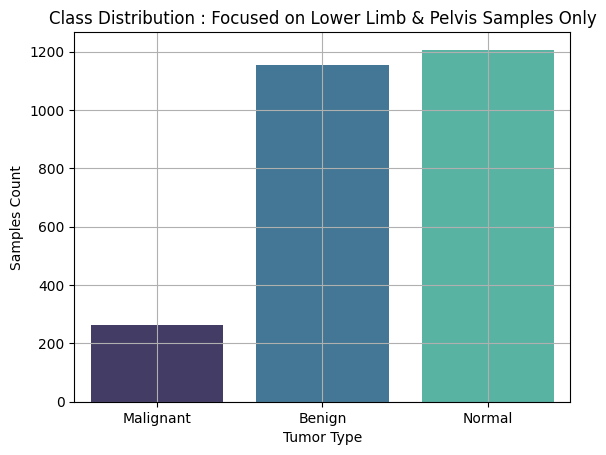

In [9]:
model_df = main_df[(main_df['lower limb']==1) | (main_df['pelvis']==1)]

print("Fcoused on lower limb and pelvis body parts only.\n")
print(f"Shape of the focused dataframe:{model_df.shape}\n")

print("Class distribution:")
print("-------------------")

print(f"{model_df['label'].value_counts()}\n")

sns.countplot(data = model_df,x='label',hue='label',palette='mako')
plt.title("Class Distribution : Focused on Lower Limb & Pelvis Samples Only")
plt.xlabel("Tumor Type")
plt.ylabel("Samples Count")
plt.grid()
plt.show()


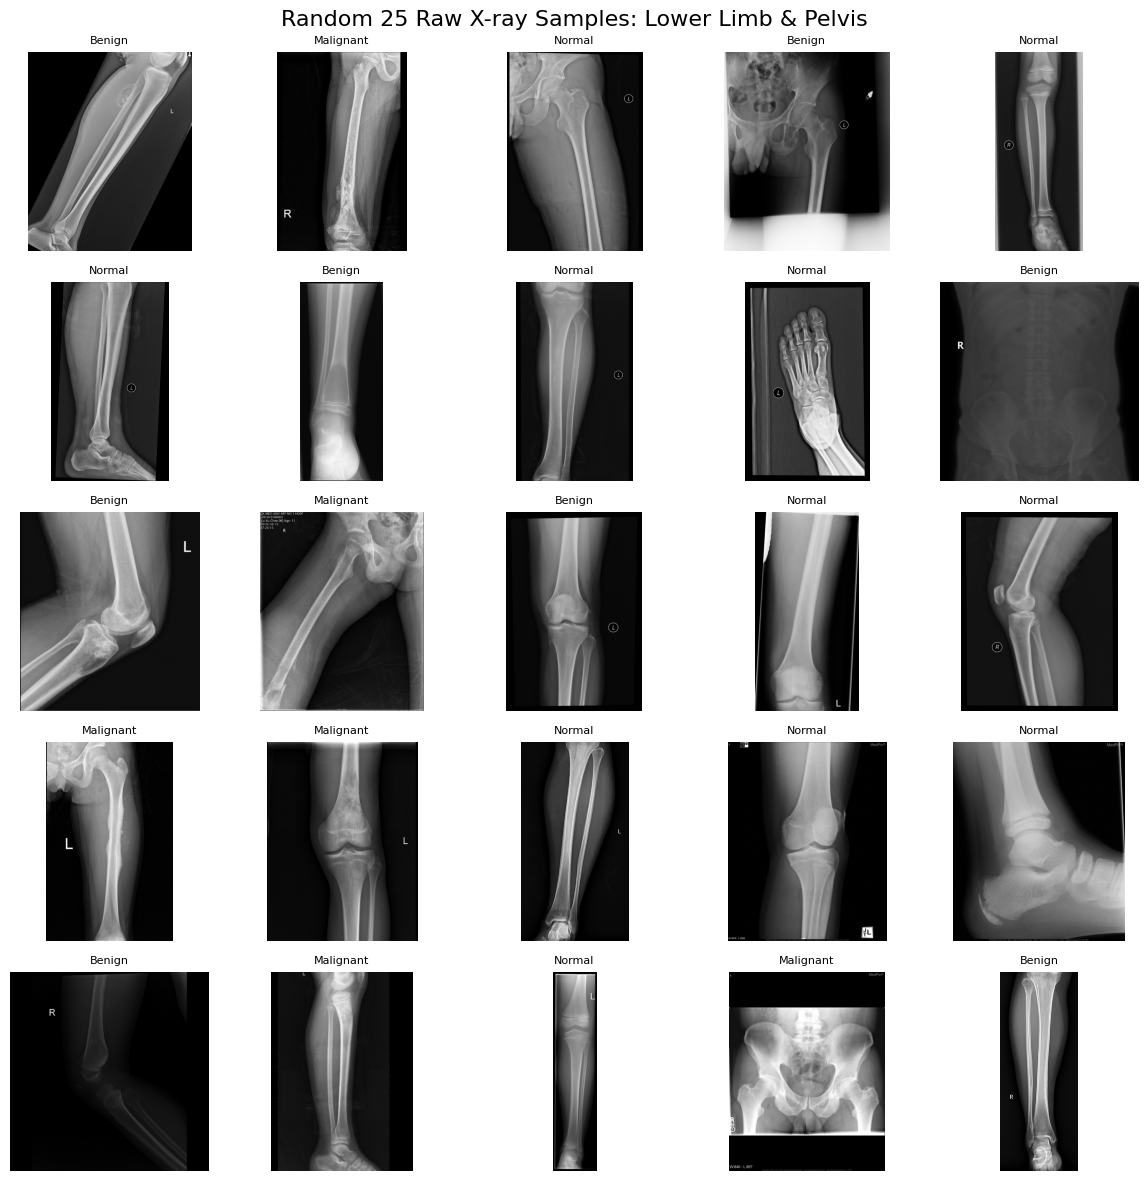

In [10]:
sample_df = model_df.sample(25, random_state=42).reset_index(drop=True)

plt.figure(figsize=(12, 12))

for i in range(25):
    img_path = sample_df.loc[i, 'image_path']
    label = sample_df.loc[i, 'label']

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue

    plt.subplot(5, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(label, fontsize=8)
    plt.axis('off')

plt.suptitle("Random 25 Raw X-ray Samples: Lower Limb & Pelvis", fontsize=16)
plt.tight_layout()
plt.show()

In [11]:
model_df.shape

(2622, 42)

In [12]:
from sklearn.model_selection import train_test_split

train_df,temp_df = train_test_split(model_df,
                                    stratify=model_df['label'],
                                    test_size = 0.35,
                                    random_state=369)

val_df,test_df = train_test_split(temp_df,
                                  stratify=temp_df['label'],
                                  test_size=20/35,
                                  random_state=369)

# Train, Validation & Test Split size:
print(f"Train Dataset Size : {train_df.shape}")
print(f"Validation Dataset Size : {val_df.shape}")
print(f"Test Dataset Size : {test_df.shape}")

Train Dataset Size : (1704, 42)
Validation Dataset Size : (393, 42)
Test Dataset Size : (525, 42)


In [13]:
train_df['label'].value_counts()

,count
label,
Normal,785
Benign,749
Malignant,170


## AUGMENTING MALIGNANT:

In [35]:
def strong_augment_pil(img: Image.Image):
    """Augmentation : Rotation, flip, zoom (crop & resize), brightness/contrast."""

    # Random rotate
    angle = random.choice([0, 90, 180, 270]) if random.random() < 0.4 else random.uniform(-20, 20)
    img = img.rotate(angle)

    # Horizontal flip
    if random.random() < 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)

    # Random zoom via center crop
    if random.random() < 0.6:
        w, h = img.size
        zoom = random.uniform(0.85, 1.0)   # crop to 85–100% area
        new_w, new_h = int(w*zoom), int(h*zoom)
        left = (w - new_w) // 2
        top  = (h - new_h) // 2
        img = img.crop((left, top, left+new_w, top+new_h))
        img = img.resize((w, h), Image.BICUBIC)

    # Brightness & contrast
    if random.random() < 0.8:
        img = ImageEnhance.Brightness(img).enhance(random.uniform(0.8, 1.2))
    if random.random() < 0.8:
        img = ImageEnhance.Contrast(img).enhance(random.uniform(0.8, 1.3))

    return img


def augment_malignant_to_target(train_df, target_per_class=None, copies_per_image=None, img_size=(224,224)):
    """
    Augment only malignant class images and save augmented images on disk.
    Return a dataframe with **all original columns** (metadata included) for original + augmented samples.
    """
    malignant_df = train_df[train_df['label'] == 'Malignant'].copy()
    benign_df    = train_df[train_df['label'] == 'Benign'].copy()
    normal_df    = train_df[train_df['label'] == 'Normal'].copy()

    counts = {
        'Normal': len(normal_df),
        'Benign': len(benign_df),
        'Malignant': len(malignant_df)
    }
    print("Pre-augmentation:", counts)

    if target_per_class is None and copies_per_image is None:
        target_per_class = max(counts['Normal'], counts['Benign'])

    if target_per_class is not None:
        need = max(0, target_per_class - counts['Malignant'])
    else:
        need = len(malignant_df) * copies_per_image

    if need == 0:
        print("No malignant augmentation needed.")
        return train_df

    aug_rows = []
    malignant_paths = malignant_df['image_path'].tolist()
    n = len(malignant_paths)

    created = 0
    idx = 0
    while created < need:
        src_row = malignant_df.iloc[idx % n]
        src_path = src_row['image_path']
        try:
            with Image.open(src_path) as img:
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                img = img.resize(img_size, Image.BICUBIC)
                img_aug = strong_augment_pil(img)

                base = os.path.splitext(os.path.basename(src_path))[0]
                out_name = f"{base}_AUG_{created:05d}.jpg"
                # Ensure the directory exists before saving
                os.makedirs(AUG_DIR, exist_ok=True)
                out_path = os.path.join(AUG_DIR, out_name)
                img_aug.save(out_path, quality=95)

                # Copy entire metadata from the source malignant row, update image_path to new augmented path
                new_row = src_row.copy()
                new_row['image_path'] = out_path

                aug_rows.append(new_row)
                created += 1
        except Exception as e:
            print(f"Aug error: {src_path} -> {e}")
        idx += 1

    aug_df = pd.DataFrame(aug_rows)
    train_df_aug = pd.concat([train_df, aug_df], ignore_index=True)

    print("Post-augmentation counts:\n", train_df_aug['label'].value_counts())
    return train_df_aug

In [36]:
AUG_DIR = os.path.join(BASE_DIR,"augmented_malignant")
os.makedirs(AUG_DIR,exist_ok=True)


max_train_class = train_df['label'].value_counts().max()
train_df_aug = augment_malignant_to_target(train_df, target_per_class=max_train_class, img_size=(224,224))

Pre-augmentation: {'Normal': 785, 'Benign': 749, 'Malignant': 170}
Post-augmentation counts:
 label
Normal       785
Malignant    785
Benign       749
Name: count, dtype: int64


In [37]:
train_df_aug.head()

,image_id,center,age,gender,hand,ulna,radius,humerus,foot,tibia,fibula,femur,hip bone,ankle-joint,knee-joint,hip-joint,wrist-joint,elbow-joint,shoulder-joint,tumor,benign,malignant,osteochondroma,multiple osteochondromas,simple bone cyst,giant cell tumor,osteofibroma,synovial osteochondroma,other bt,osteosarcoma,other mt,upper limb,lower limb,pelvis,frontal,lateral,oblique,label,image_path,image_id_clean,difficulty_score,difficulty_level
0,IMG001709.jpeg,3,18,F,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,Benign,/content/drive/MyDrive/CV_Project/BTXRD/images...,IMG001709,2,easy
1,IMG002665.jpeg,1,37,M,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,Normal,/content/drive/MyDrive/CV_Project/BTXRD/images...,IMG002665,2,easy
2,IMG002374.jpeg,1,18,M,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,Normal,/content/drive/MyDrive/CV_Project/BTXRD/images...,IMG002374,3,medium
3,IMG001960.jpeg,1,60,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,Normal,/content/drive/MyDrive/CV_Project/BTXRD/images...,IMG001960,3,medium
4,IMG002289.jpeg,1,12,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,Normal,/content/drive/MyDrive/CV_Project/BTXRD/images...,IMG002289,5,hard


### **Define Transform (for CheXpert model)**

In [19]:
from torchvision import transforms
IMG_SIZE = 224
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.GaussianBlur(3, sigma=(0.1, 1.0)),  # optional
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



### **Define Custom Dataset**

In [20]:
from torch.utils.data import Dataset
from PIL import Image
from copy import deepcopy

class XRayDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        self.label2idx = {'Normal': 0, 'Benign': 1, 'Malignant': 2}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'image_path']
        label_str = self.df.loc[idx, 'label']
        label = self.label2idx[label_str]

        # Load image
        img = Image.open(img_path)
        if img.mode != 'L':  # L = grayscale
            img = img.convert('L')

        if self.transform:
            img = self.transform(img)

        return img, label


### **2. Create Custom Dataset & Dataloaders**

In [21]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.classes = sorted(self.df['label'].unique())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'image_path']
        label = self.df.loc[idx, 'label']
        image = Image.open(img_path).convert("L")  # Convert to grayscale (1 channel)
        if self.transform:
            image = self.transform(image)
        return image, self.class_to_idx[label]

# Image size for DenseNet121
IMG_SIZE = 224
BATCH_SIZE = 32

# Grayscale normalization for CheXpert DenseNet121
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    # You can add custom augmentations here that work on grayscale images
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Single channel mean/std
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Single channel mean/std
])

# Create datasets
train_dataset = CustomImageDataset(train_df_aug, transform=train_transform)
val_dataset = CustomImageDataset(val_df, transform=val_test_transform)
test_dataset = CustomImageDataset(test_df, transform=val_test_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

num_classes = len(train_dataset.classes)


### **3. Load DenseNet121 with CheXpert weights**

In [23]:
import torch.nn as nn
import torchxrayvision as xrv
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 3
model = DenseNet121CheXpertFineTune(num_classes=num_classes).to(device)

class DenseNet121CheXpertFineTune(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.backbone = xrv.models.DenseNet(weights="densenet121-res224-chex")

        # Freeze all layers (Phase 1)
        for param in self.backbone.parameters():
            param.requires_grad = False

        self.features = self.backbone.features  # only convolutional layers

        # Custom classifier head
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Instantiate model
model = DenseNet121CheXpertFineTune(num_classes=num_classes).to(device)


### **4. Phase 1: Freeze Base Layers, Train Classifier Head**

In [24]:
# Freeze base feature extractor again (redundancy is fine)
for param in model.features.parameters():
    param.requires_grad = False

# --------- Step 2: Define Loss, Optimizer, Scheduler ---------
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Weight decay for regularization
optimizer = optim.Adam(model.classifier.parameters(), lr=3e-3, weight_decay=1e-5)

# Reduce LR if validation loss plateaus
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3)

print("Model ready for Phase 1 training (classifier head only).")


Model ready for Phase 1 training (classifier head only).


### **5. Training Loop with Callbacks (Phase 1)**

In [ ]:
import pandas as pd
from copy import deepcopy
from tqdm import tqdm

def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=10,
    early_stop_patience=5,
    save_path="/content/drive/MyDrive/CV_Project/best_model.pth",
    log_path="/content/drive/MyDrive/CV_Project/training_log.csv"
):
    best_val_loss = float('inf')
    no_improve_epochs = 0
    best_model_wts = deepcopy(model.state_dict())

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # --- Train ---
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # --- Validation ---
        model.eval()
        running_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels).item()
                total += labels.size(0)

        val_loss = running_loss / total
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # --- Logging ---
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        scheduler.step(val_loss)
        for param_group in optimizer.param_groups:
            print(f"Current learning rate: {param_group['lr']:.6f}")

        # --- Early Stopping & Save Best Model ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = deepcopy(model.state_dict())
            no_improve_epochs = 0
            torch.save(model.state_dict(), save_path)
            print("New best model saved.")
        else:
            no_improve_epochs += 1
            print(f"No improvement for {no_improve_epochs} epoch(s).")
            if no_improve_epochs >= early_stop_patience:
                print("Early stopping triggered.")
                break

    # Finalize
    model.load_state_dict(best_model_wts)
    print("Best model weights restored.")

    # Save logs
    log_df = pd.DataFrame({
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_acc": train_accs,
        "val_acc": val_accs
    })
    log_df.to_csv(log_path, index=False)
    print("Training logs saved.")

    return model, log_df


In [ ]:
model, log_df = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=25,
    early_stop_patience=6,
    save_path="/content/drive/MyDrive/CV_Project/best_model_phase1.pth",
    log_path="/content/drive/MyDrive/CV_Project/training_log_phase1.csv"
)



Epoch 1/25


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.38it/s]


Train Loss: 1.0208 | Train Acc: 0.5334 | Val Loss: 2.7251 | Val Acc: 0.4402
Current learning rate: 0.003000
New best model saved.

Epoch 2/25


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.37it/s]


Train Loss: 0.9545 | Train Acc: 0.5834 | Val Loss: 0.9571 | Val Acc: 0.6107
Current learning rate: 0.003000
New best model saved.

Epoch 3/25


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.47it/s]


Train Loss: 0.9364 | Train Acc: 0.5938 | Val Loss: 0.9328 | Val Acc: 0.5929
Current learning rate: 0.003000
New best model saved.

Epoch 4/25


Validation: 100%|██████████| 13/13 [00:03<00:00,  4.14it/s]


Train Loss: 0.9314 | Train Acc: 0.6007 | Val Loss: 0.8648 | Val Acc: 0.6209
Current learning rate: 0.003000
New best model saved.

Epoch 5/25


Validation: 100%|██████████| 13/13 [00:03<00:00,  4.33it/s]


Train Loss: 0.9148 | Train Acc: 0.6175 | Val Loss: 0.9028 | Val Acc: 0.6107
Current learning rate: 0.003000
No improvement for 1 epoch(s).

Epoch 6/25


Validation: 100%|██████████| 13/13 [00:03<00:00,  4.33it/s]


Train Loss: 0.9108 | Train Acc: 0.6197 | Val Loss: 0.8662 | Val Acc: 0.6412
Current learning rate: 0.003000
No improvement for 2 epoch(s).

Epoch 7/25


Validation: 100%|██████████| 13/13 [00:03<00:00,  4.31it/s]


Train Loss: 0.9097 | Train Acc: 0.6283 | Val Loss: 0.8920 | Val Acc: 0.6183
Current learning rate: 0.003000
No improvement for 3 epoch(s).

Epoch 8/25


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.46it/s]


Train Loss: 0.9016 | Train Acc: 0.6287 | Val Loss: 0.8638 | Val Acc: 0.6489
Current learning rate: 0.003000
New best model saved.

Epoch 9/25


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.52it/s]


Train Loss: 0.8908 | Train Acc: 0.6326 | Val Loss: 0.8895 | Val Acc: 0.6387
Current learning rate: 0.003000
No improvement for 1 epoch(s).

Epoch 10/25


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.34it/s]


Train Loss: 0.8943 | Train Acc: 0.6287 | Val Loss: 0.8792 | Val Acc: 0.6336
Current learning rate: 0.003000
No improvement for 2 epoch(s).

Epoch 11/25


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.44it/s]


Train Loss: 0.8848 | Train Acc: 0.6369 | Val Loss: 0.8623 | Val Acc: 0.6387
Current learning rate: 0.003000
New best model saved.

Epoch 12/25


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.50it/s]


Train Loss: 0.8772 | Train Acc: 0.6292 | Val Loss: 0.8277 | Val Acc: 0.6438
Current learning rate: 0.003000
New best model saved.

Epoch 13/25


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.47it/s]


Train Loss: 0.8738 | Train Acc: 0.6352 | Val Loss: 0.8626 | Val Acc: 0.6489
Current learning rate: 0.003000
No improvement for 1 epoch(s).

Epoch 14/25


Validation: 100%|██████████| 13/13 [00:03<00:00,  4.18it/s]


Train Loss: 0.8739 | Train Acc: 0.6421 | Val Loss: 0.8843 | Val Acc: 0.6438
Current learning rate: 0.003000
No improvement for 2 epoch(s).

Epoch 15/25


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.43it/s]


Train Loss: 0.8721 | Train Acc: 0.6537 | Val Loss: 0.8454 | Val Acc: 0.6565
Current learning rate: 0.003000
No improvement for 3 epoch(s).

Epoch 16/25


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.52it/s]


Train Loss: 0.8614 | Train Acc: 0.6507 | Val Loss: 0.8819 | Val Acc: 0.6336
Current learning rate: 0.000900
No improvement for 4 epoch(s).

Epoch 17/25


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.56it/s]


Train Loss: 0.8503 | Train Acc: 0.6503 | Val Loss: 0.8435 | Val Acc: 0.6514
Current learning rate: 0.000900
No improvement for 5 epoch(s).

Epoch 18/25


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.39it/s]

Train Loss: 0.8288 | Train Acc: 0.6736 | Val Loss: 0.8484 | Val Acc: 0.6616
Current learning rate: 0.000900
No improvement for 6 epoch(s).
Early stopping triggered.
Best model weights restored.
Training logs saved.


### **6. Phase 2: Unfreeze last 60 layers & Fine-Tune**

In [ ]:
from torch.optim import AdamW,Adam

# Load Phase-1 model weights
model.load_state_dict(torch.load("/content/drive/MyDrive/CV_Project/best_model_phase1.pth"))

# Unfreeze the last 40 layers
features_list = list(model.features.children())
for layer in features_list[-60:]:
    for param in layer.parameters():
        param.requires_grad = True

# Fix: make sure all unfrozen params are included
params_to_train = list(model.classifier.parameters()) + \
                  [p for layer in features_list[-60:] for p in layer.parameters()]

# Use AdamW with smaller LR

optimizer = Adam(params_to_train, lr=3e-5, weight_decay=1e-6)

# Train again
model, log_df = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=30,
    early_stop_patience=5,
    save_path="/content/drive/MyDrive/CV_Project/best_model_ft_40layers.pth",
    log_path="/content/drive/MyDrive/CV_Project/training_log_ft_40layers.csv"
)



Epoch 1/30


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.47it/s]


Train Loss: 0.8642 | Train Acc: 0.6455 | Val Loss: 0.8339 | Val Acc: 0.6438
Current learning rate: 0.000030
New best model saved.

Epoch 2/30


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.51it/s]


Train Loss: 0.8476 | Train Acc: 0.6632 | Val Loss: 0.8337 | Val Acc: 0.6489
Current learning rate: 0.000030
New best model saved.

Epoch 3/30


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.37it/s]


Train Loss: 0.8404 | Train Acc: 0.6559 | Val Loss: 0.8379 | Val Acc: 0.6692
Current learning rate: 0.000030
No improvement for 1 epoch(s).

Epoch 4/30


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.38it/s]


Train Loss: 0.8047 | Train Acc: 0.6969 | Val Loss: 0.8338 | Val Acc: 0.6616
Current learning rate: 0.000030
No improvement for 2 epoch(s).

Epoch 5/30


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.40it/s]


Train Loss: 0.8255 | Train Acc: 0.6744 | Val Loss: 0.8325 | Val Acc: 0.6718
Current learning rate: 0.000030
New best model saved.

Epoch 6/30


Validation: 100%|██████████| 13/13 [00:03<00:00,  4.31it/s]


Train Loss: 0.8173 | Train Acc: 0.6792 | Val Loss: 0.8229 | Val Acc: 0.6692
Current learning rate: 0.000030
New best model saved.

Epoch 7/30


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.46it/s]


Train Loss: 0.8046 | Train Acc: 0.6930 | Val Loss: 0.8297 | Val Acc: 0.6768
Current learning rate: 0.000030
No improvement for 1 epoch(s).

Epoch 8/30


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.41it/s]


Train Loss: 0.8095 | Train Acc: 0.6917 | Val Loss: 0.8326 | Val Acc: 0.6692
Current learning rate: 0.000030
No improvement for 2 epoch(s).

Epoch 9/30


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.46it/s]


Train Loss: 0.8025 | Train Acc: 0.6969 | Val Loss: 0.8377 | Val Acc: 0.6819
Current learning rate: 0.000030
No improvement for 3 epoch(s).

Epoch 10/30


Validation: 100%|██████████| 13/13 [00:03<00:00,  4.27it/s]


Train Loss: 0.7952 | Train Acc: 0.6960 | Val Loss: 0.8245 | Val Acc: 0.6743
Current learning rate: 0.000030
No improvement for 4 epoch(s).

Epoch 11/30


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.39it/s]


Train Loss: 0.7933 | Train Acc: 0.7012 | Val Loss: 0.8227 | Val Acc: 0.6718
Current learning rate: 0.000030
New best model saved.

Epoch 12/30


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.43it/s]


Train Loss: 0.7945 | Train Acc: 0.6951 | Val Loss: 0.8262 | Val Acc: 0.6819
Current learning rate: 0.000030
No improvement for 1 epoch(s).

Epoch 13/30


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.47it/s]


Train Loss: 0.7899 | Train Acc: 0.7025 | Val Loss: 0.8164 | Val Acc: 0.6768
Current learning rate: 0.000030
New best model saved.

Epoch 14/30


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.39it/s]


Train Loss: 0.7792 | Train Acc: 0.7111 | Val Loss: 0.8172 | Val Acc: 0.6819
Current learning rate: 0.000030
No improvement for 1 epoch(s).

Epoch 15/30


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.45it/s]


Train Loss: 0.7757 | Train Acc: 0.7063 | Val Loss: 0.8140 | Val Acc: 0.6972
Current learning rate: 0.000030
New best model saved.

Epoch 16/30


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.46it/s]


Train Loss: 0.7793 | Train Acc: 0.7154 | Val Loss: 0.8165 | Val Acc: 0.6921
Current learning rate: 0.000030
No improvement for 1 epoch(s).

Epoch 17/30


Validation: 100%|██████████| 13/13 [00:03<00:00,  4.31it/s]


Train Loss: 0.7723 | Train Acc: 0.7059 | Val Loss: 0.8139 | Val Acc: 0.6870
Current learning rate: 0.000030
New best model saved.

Epoch 18/30


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.37it/s]


Train Loss: 0.7815 | Train Acc: 0.7007 | Val Loss: 0.8177 | Val Acc: 0.7023
Current learning rate: 0.000030
No improvement for 1 epoch(s).

Epoch 19/30


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.35it/s]


Train Loss: 0.7608 | Train Acc: 0.7266 | Val Loss: 0.8271 | Val Acc: 0.6921
Current learning rate: 0.000030
No improvement for 2 epoch(s).

Epoch 20/30


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.45it/s]


Train Loss: 0.7705 | Train Acc: 0.7163 | Val Loss: 0.8206 | Val Acc: 0.6972
Current learning rate: 0.000030
No improvement for 3 epoch(s).

Epoch 21/30


Validation: 100%|██████████| 13/13 [00:03<00:00,  4.16it/s]


Train Loss: 0.7576 | Train Acc: 0.7163 | Val Loss: 0.8129 | Val Acc: 0.6947
Current learning rate: 0.000030
New best model saved.

Epoch 22/30


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.48it/s]


Train Loss: 0.7576 | Train Acc: 0.7223 | Val Loss: 0.8125 | Val Acc: 0.6997
Current learning rate: 0.000030
New best model saved.

Epoch 23/30


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.41it/s]


Train Loss: 0.7546 | Train Acc: 0.7240 | Val Loss: 0.8058 | Val Acc: 0.7048
Current learning rate: 0.000030
New best model saved.

Epoch 24/30


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.44it/s]


Train Loss: 0.7599 | Train Acc: 0.7257 | Val Loss: 0.8315 | Val Acc: 0.6972
Current learning rate: 0.000030
No improvement for 1 epoch(s).

Epoch 25/30


Validation: 100%|██████████| 13/13 [00:03<00:00,  4.32it/s]


Train Loss: 0.7525 | Train Acc: 0.7426 | Val Loss: 0.8149 | Val Acc: 0.6921
Current learning rate: 0.000030
No improvement for 2 epoch(s).

Epoch 26/30


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.39it/s]


Train Loss: 0.7600 | Train Acc: 0.7150 | Val Loss: 0.8102 | Val Acc: 0.7023
Current learning rate: 0.000030
No improvement for 3 epoch(s).

Epoch 27/30


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.51it/s]


Train Loss: 0.7522 | Train Acc: 0.7240 | Val Loss: 0.7994 | Val Acc: 0.7048
Current learning rate: 0.000030
New best model saved.

Epoch 28/30


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.40it/s]


Train Loss: 0.7418 | Train Acc: 0.7413 | Val Loss: 0.7957 | Val Acc: 0.6947
Current learning rate: 0.000030
New best model saved.

Epoch 29/30


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.42it/s]


Train Loss: 0.7435 | Train Acc: 0.7309 | Val Loss: 0.8044 | Val Acc: 0.7048
Current learning rate: 0.000030
No improvement for 1 epoch(s).

Epoch 30/30


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.43it/s]

Train Loss: 0.7454 | Train Acc: 0.7279 | Val Loss: 0.7985 | Val Acc: 0.7023
Current learning rate: 0.000030
No improvement for 2 epoch(s).
Best model weights restored.
Training logs saved.


### **EVALUATION:**

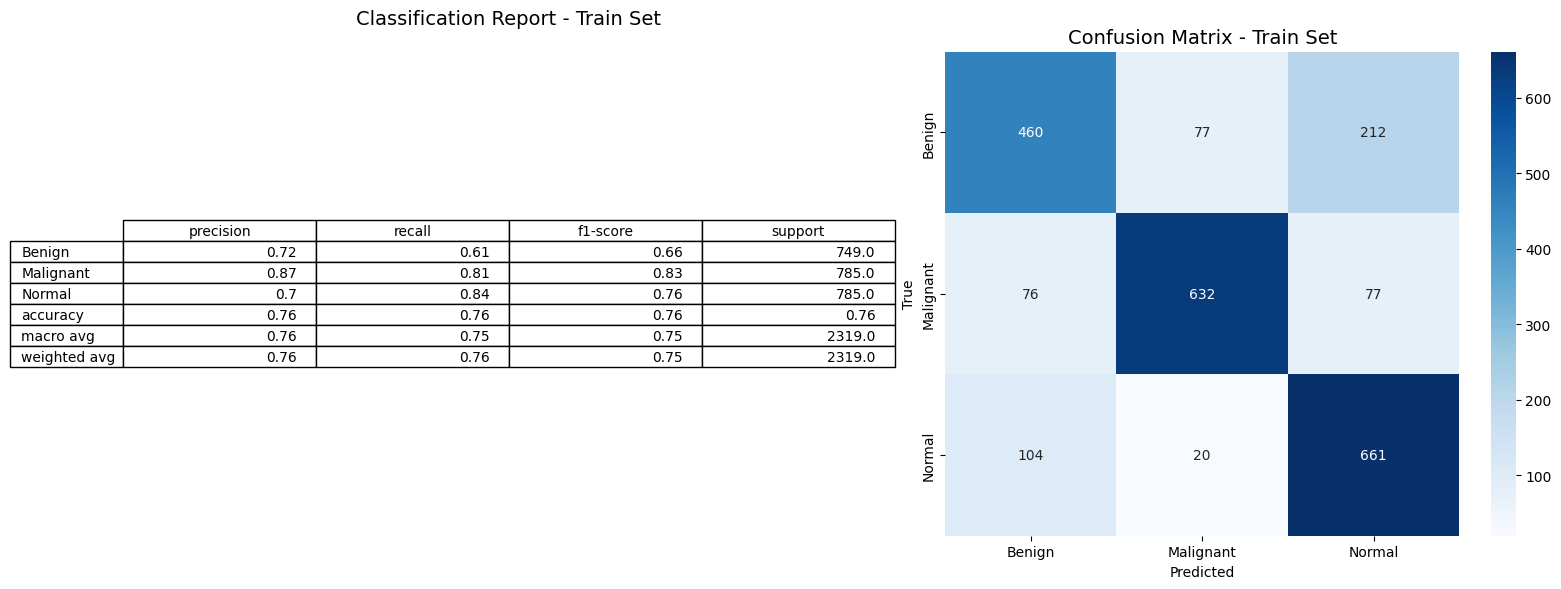

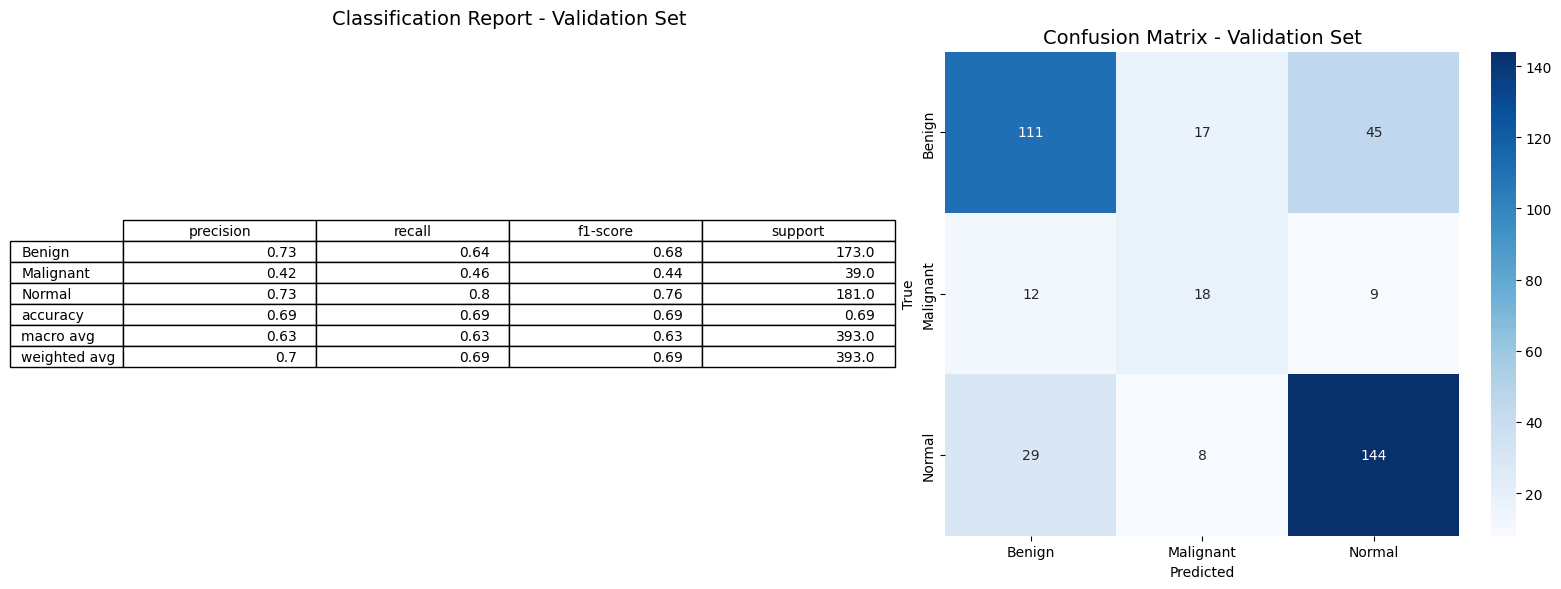

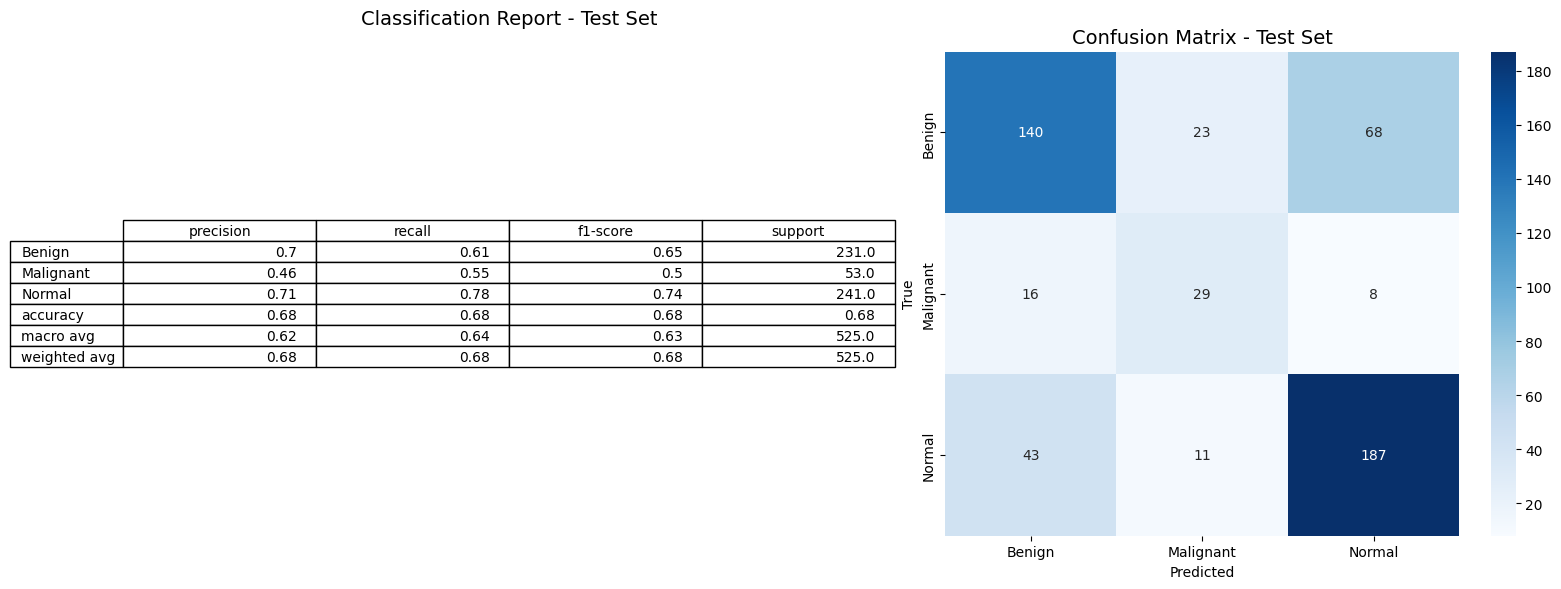

In [38]:
save_path = "/content/drive/MyDrive/CV_Project/best_model_ft_40layers.pth"

model = DenseNet121CheXpertFineTune(num_classes=3)
model.load_state_dict(torch.load(save_path, map_location=torch.device('cpu')))
model = model.to(device)
model.eval()

class_names = train_loader.dataset.classes

evaluate_model(model, train_loader, device, class_names, dataset_name="Train Set")
evaluate_model(model, val_loader, device, class_names, dataset_name="Validation Set")
evaluate_model(model, test_loader, device, class_names, dataset_name="Test Set")

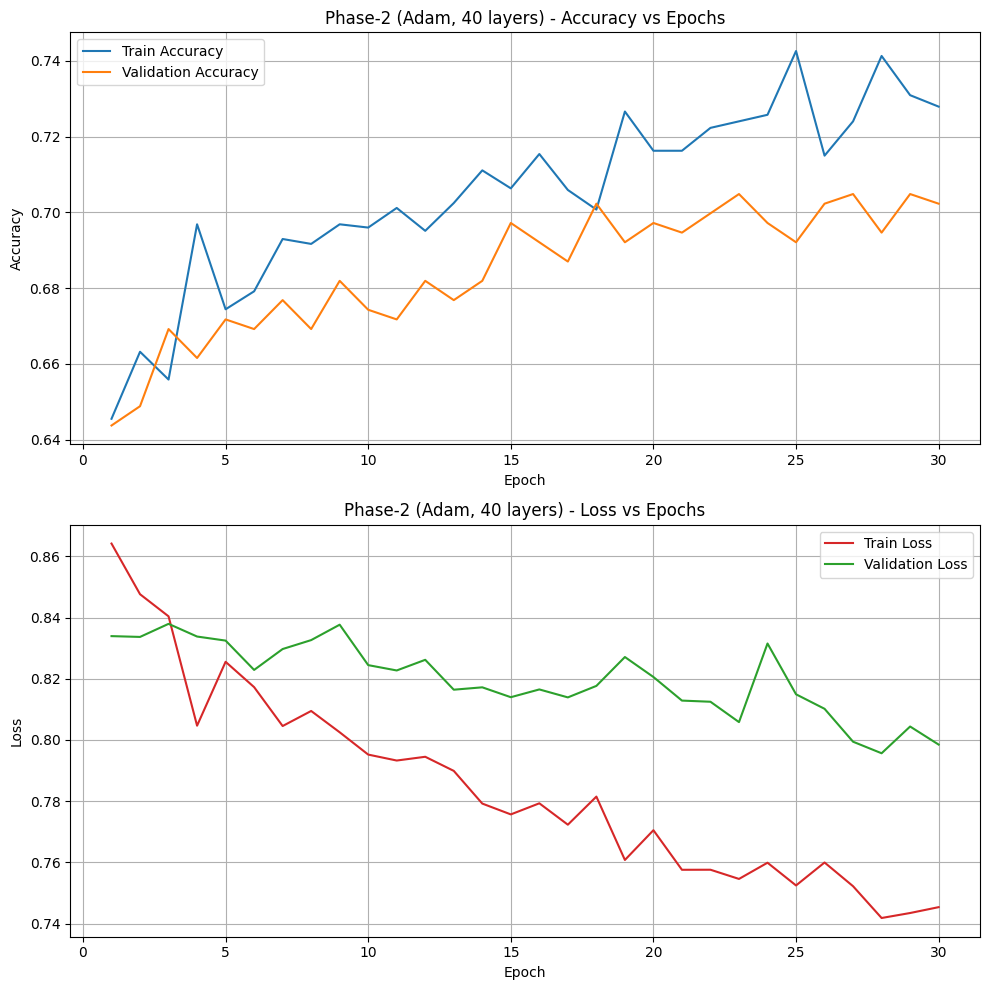

In [29]:
log_path = "/content/drive/MyDrive/CV_Project/training_log_ft_40layers.csv"

log_df = pd.read_csv(log_path)
plot_training_curves(log_df, title_prefix="Phase-2 (Adam, 40 layers) - ")